In [1]:
import numpy as np
import graspy

from combining_representations import combining_representations as cr
from combining_representations import utils

from sklearn.metrics import pairwise_distances

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook as tqdm

In [2]:
# Set up - Generate some latent positions and define the embedding / distance functions

n, d = 50, 2
acorn=18008
X = utils.generate_latent_positions(n, d, acorn=acorn)
X0 = np.array([0.5, 0.5])[np.newaxis, :]
X = np.concatenate((X0, X), axis=0)

X[42] = X[42] + 0.02*(X[42] - X[0])

P = X @ X.T

h=0.1
alphas = np.arange(0,1+h,step=h)

embedding_functions = [graspy.embed.AdjacencySpectralEmbed(n_components=2).fit_transform,
                        graspy.embed.LaplacianSpectralEmbed(n_components=2).fit_transform]
covariance_functions = [utils.identity, utils.identity]

J=len(embedding_functions)

alpha_star = alphas[2]

In [3]:
# Find representations and find the n_inds closest vertices to v* as defined by the defined representations

X_hat = graspy.embed.AdjacencySpectralEmbed(n_components=2).fit_transform(P)
ase_dist = pairwise_distances(X_hat, X_hat)

X_bre = np.sqrt(n) * graspy.embed.LaplacianSpectralEmbed(n_components=2).fit_transform(P)
lse_dist = pairwise_distances(X_bre, X_bre)

alpha_star_dist = (1-alpha_star) * lse_dist + alpha_star*ase_dist
alpha_star_dist = (alpha_star_dist + alpha_star_dist.T)/2

alpha_star_embed = graspy.embed.ClassicalMDS(n_components=2, dissimilarity='precomputed').fit_transform(alpha_star_dist)
alpha_star_embed = alpha_star_embed @ utils.generate_2d_rotation(theta=np.pi/2)

dist_matrix = np.vstack((ase_dist[0,:],lse_dist[0,:])).T

n_inds = 5+1
S_indices = utils.generate_S_indices(dist_matrix, alpha_star, n_inds=n_inds)
S_indices_ASE = utils.generate_S_indices(dist_matrix, 1.0, n_inds=n_inds)
S_indices_LSE = utils.generate_S_indices(dist_matrix, 0.0, n_inds=n_inds)

In [4]:
# Closest vertices to v* that is not in S

s_star = S_indices[-1]
ase = [ind for ind in S_indices_ASE if ind not in S_indices[:-1]][0]
lse = [ind for ind in S_indices_LSE if ind not in S_indices[:-1]][0]

points = np.array([lse, S_indices[-1], ase])
embeds = [X_bre, alpha_star_embed, X_hat]
        
colors = sns.color_palette('Set1')
r=colors[0]
b=colors[1]
g=colors[2]
p=colors[3]
o=colors[4]
y=colors[5]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

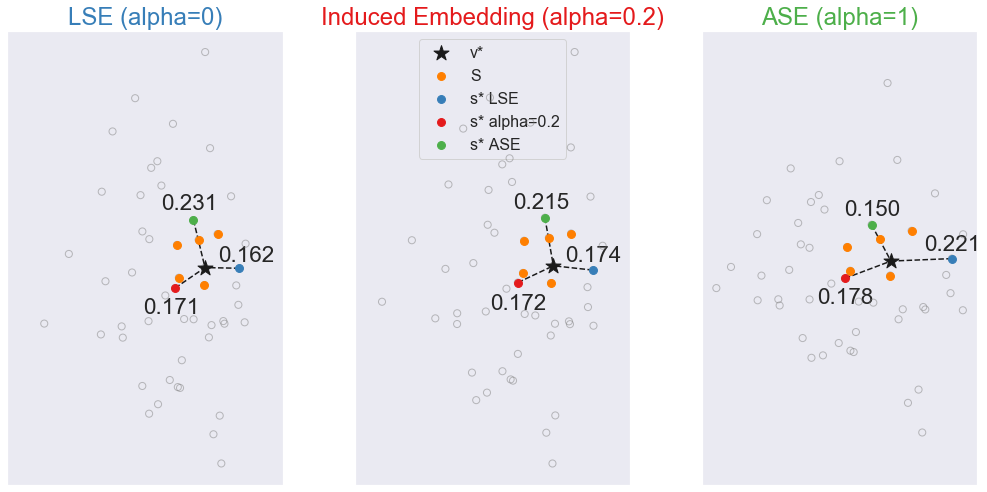

In [5]:
# Visualize embeddings

sns.set()
fig, ax = plt.subplots(1,3, figsize=(14,7))

alpha=0.5
s=50

for i, emb in enumerate(embeds):
    for j, p in enumerate(points):
        ax[i].plot([emb[p, 0], emb[0, 0]], [emb[p, 1], emb[0,1]], ls='--', c='k', zorder=i+j+1)
        
ax[2].scatter(X_hat[:, 0], X_hat[:, 1], alpha=alpha, s=s, edgecolors='grey', marker='o', 
              facecolors='none', zorder=i+j+2)
ax[0].scatter(X_bre[:, 0], X_bre[:, 1], alpha=alpha, s=s, edgecolors='grey', marker='o', 
              facecolors='none', zorder=i+j+2)
ax[1].scatter(alpha_star_embed[:, 0], alpha_star_embed[:, 1], alpha=alpha, s=s, edgecolors='grey', marker='o', 
              facecolors='none', zorder=i+j+2)

ax[2].scatter(X_hat[0, 0], X_hat[0, 1], c='k', s=250, 
              marker='*', zorder=i+j+2)
ax[0].scatter(X_bre[0, 0], X_bre[0, 1], c='k', label='v*', s=250, 
              marker='*', zorder=i+j+2)
ax[1].scatter(alpha_star_embed[0, 0], alpha_star_embed[0, 1], c='k', s=250, 
              marker='*', zorder=i+j+2, label='v*')

ax[2].scatter(X_hat[S_indices[:-1], 0], X_hat[S_indices[:-1], 1], marker='.', c=o, s=5*s, zorder=i+j+2)
ax[0].scatter(X_bre[S_indices[:-1], 0], X_bre[S_indices[:-1], 1], label='S', marker='.', c=o, s=5*s, zorder=i+j+2)
ax[1].scatter(alpha_star_embed[S_indices[:-1], 0], alpha_star_embed[S_indices[:-1], 1], marker='.', c=o, s=5*s, zorder=i+j+2, label='S')


ax[1].scatter(alpha_star_embed[lse, 0], alpha_star_embed[lse, 1], c=b, 
              marker='.', s=250, zorder=i+j+2, label='s* LSE')
ax[1].scatter(alpha_star_embed[S_indices[-1], 0], alpha_star_embed[S_indices[-1], 1], c=r, 
              marker='.', s=250, zorder=i+j+2, label='s* alpha=0.2')
ax[1].scatter(alpha_star_embed[ase, 0], alpha_star_embed[ase, 1], c=g, 
              marker='.', s=250, zorder=i+j+2, label='s* ASE')


ax[2].scatter(X_hat[lse, 0], X_hat[lse, 1], c=b, 
              marker='.', s=250, zorder=i+j+2)
ax[2].scatter(X_hat[S_indices[-1], 0], X_hat[S_indices[-1], 1], c=r, 
              marker='.', s=250, zorder=i+j+2)
ax[2].scatter(X_hat[ase, 0], X_hat[ase, 1], c=g, 
              marker='.', s=250, zorder=i+j+2)


ax[0].scatter(X_bre[lse, 0], X_bre[lse, 1], c=b, label='s* LSE', 
              marker='.', s=250, zorder=i+j+2)
ax[0].scatter(X_bre[S_indices[-1], 0], X_bre[S_indices[-1], 1], c=r,label='s* alpha=0.2', 
              marker='.', s=250, zorder=i+j+2)
ax[0].scatter(X_bre[ase, 0], X_bre[ase, 1], c=g, label='s* ASE', 
              marker='.', s=250, zorder=i+j+2)


title_fs=24
ax[1].axis('equal')
ax[1].set_yticks([])
ax[1].set_xticks([])
ax[1].set_title('Induced Embedding (alpha=0.2)', color=r, fontsize=title_fs)

ax[2].axis('equal')
ax[2].set_yticks([])
ax[2].set_xticks([])
ax[2].set_title('ASE (alpha=1)', color=g, fontsize=title_fs)

ax[0].axis('equal')
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_title('LSE (alpha=0)', color=b, fontsize=title_fs)
        

text_fs=22.5
ax[0].text(X_bre[lse,0]-0.1, X_bre[lse,1]+0.03, f"{np.linalg.norm(X_bre[lse] - X_bre[0]):0.3f}", fontsize=text_fs)
ax[0].text(X_bre[S_indices[-1],0]-0.15, X_bre[S_indices[-1],1]-0.12, f"{np.linalg.norm(X_bre[S_indices[-1]] - X_bre[0]):0.3f}", fontsize=text_fs)
ax[0].text(X_bre[ase,0]-0.15, X_bre[ase,1]+0.05, f"{np.linalg.norm(X_bre[ase] - X_bre[0]):0.3f}", fontsize=text_fs)

ax[1].text(alpha_star_embed[lse,0]-0.12, alpha_star_embed[lse,1]+0.04, 
           f"{np.linalg.norm(alpha_star_embed[lse] - alpha_star_embed[0]):0.3f}", fontsize=text_fs)
ax[1].text(alpha_star_embed[S_indices[-1],0]-0.12, alpha_star_embed[S_indices[-1],1]-0.12, 
           f"{np.linalg.norm(alpha_star_embed[S_indices[-1]] - alpha_star_embed[0]):0.3f}", fontsize=text_fs)
ax[1].text(alpha_star_embed[ase,0]-0.14, alpha_star_embed[ase,1]+0.04, 
           f"{np.linalg.norm(alpha_star_embed[ase] - alpha_star_embed[0]):0.3f}", fontsize=text_fs)

ax[2].text(X_hat[lse,0]-0.1, X_hat[lse,1]+0.03, f"{np.linalg.norm(X_hat[lse] - X_hat[0]):0.3f}", fontsize=text_fs)
ax[2].text(X_hat[S_indices[-1],0]-0.1, X_hat[S_indices[-1],1]-0.09, f"{np.linalg.norm(X_hat[S_indices[-1]] - X_hat[0]):0.3f}", fontsize=text_fs)
ax[2].text(X_hat[ase,0]-0.1, X_hat[ase,1]+0.035, f"{np.linalg.norm(X_hat[ase] - X_hat[0]):0.3f}", fontsize=text_fs)

ax[1].legend(loc='upper center', fontsize=16)


plt.tight_layout()

In [6]:
# Analytic "simulation" example
mrrs_by_alpha_poc = np.zeros((len(alphas), 2, J+1))
alpha_hats_by_alpha_poc = np.zeros((len(alphas), 2))

n_inds = 5+1
s_stars =np.array([-1])
nmc=500

metric = 'mrr'

for i, alpha in enumerate(tqdm(alphas)):
    alpha_hats_by_alpha_poc[i], mrrs_by_alpha_poc[i] = utils.monte_carlo(2, P, embedding_functions,
                                                           covariance_functions,
                                                           alpha, n_inds, s_stars=s_stars, acorn=acorn, latent=True, 
                                                           metric=metric, poc=True)

Using license file C:\Users\hhelm\gurobi.lic
Academic license - for non-commercial use only



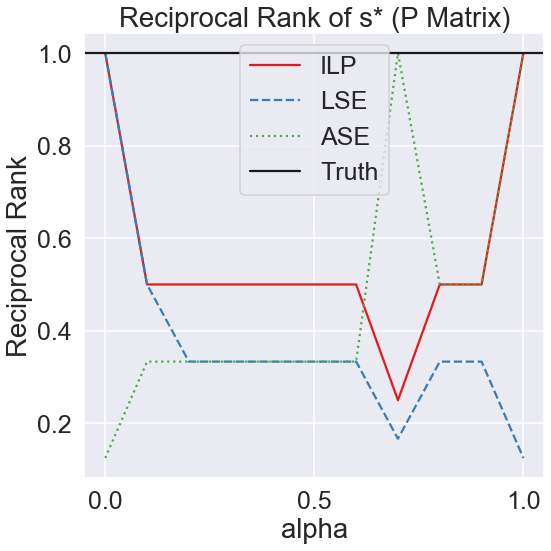

In [7]:
sns.set(context='talk')
labels = ['ASE', 'LSE', 'ILP']
ls = ['-', '--', ':']
mean_mrrs = np.mean(mrrs_by_alpha_poc, axis=1)
std_err_mrrs = np.std(mrrs_by_alpha_poc, axis=1, ddof=1) / np.sqrt(nmc)

fig, ax = plt.subplots(1,1, figsize=(8,8))
c = sns.color_palette('Set1', n_colors=J+1)

for i in range(J+1):
    ax.plot(alphas, mean_mrrs[:, -i-1], label = labels[-i-1], c=c[i], ls=ls[i])
    ax.fill_between(alphas, 
        mean_mrrs[:, -i-1] + 1.96*std_err_mrrs[:, -i-1], 
        mean_mrrs[:, -i-1] - 1.96*std_err_mrrs[:, -i-1], 
        where=mean_mrrs[:, -i-1] + 1.96*std_err_mrrs[:, -i-1] >= mean_mrrs[:, -i-1] - 1.96*std_err_mrrs[:, -i-1], 
        facecolor=c[i], 
        alpha=0.15,
        interpolate=True)

ax.set_xlabel('alpha', fontsize=27.5)

ax.set_title('Reciprocal Rank of s* (P Matrix)', fontsize=27.5)
ax.set_ylabel('Reciprocal Rank', fontsize=27.5)
ax.axhline(y=1, label='Truth', c='k')
ax.tick_params(labelsize=25)
ax.set_xticks([0, 0.5, 1])

ax.legend(loc='upper center', fontsize=25)
plt.tight_layout()

In [8]:
# "Noisy" simulation example; the example in the paper has nmc=100 and k=1000

nmc=10
mrrs_by_alpha = np.zeros((len(alphas), nmc, J+1))
alpha_hats_by_alpha = np.zeros((len(alphas), nmc))

n_inds = 5+1
s_stars =np.array([-1])
k=100

metric = 'mrr'

for i, alpha in enumerate(tqdm(alphas)):
    alpha_hats_by_alpha[i], mrrs_by_alpha[i] = utils.monte_carlo(nmc, P, embedding_functions,
                                                           covariance_functions,
                                                           alpha, n_inds, s_stars=s_stars, acorn=acorn, latent=True, 
                                                           metric=metric, k=k, poc=False)

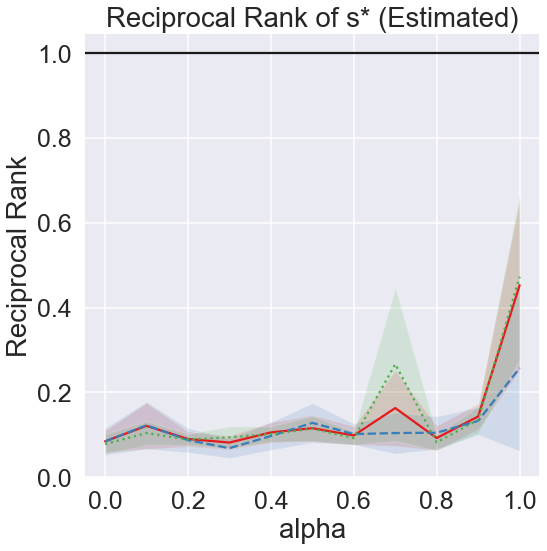

In [9]:
mean_mrrs = np.mean(mrrs_by_alpha, axis=1)
std_err_mrrs = np.std(mrrs_by_alpha, axis=1, ddof=1) / np.sqrt(nmc)

fig, ax = plt.subplots(1,1, figsize=(8,8))
c = sns.color_palette('Set1', n_colors=J+1)

for i in range(J+1):
    ax.plot(alphas, mean_mrrs[:, -i-1], label = labels[-i-1], c=c[i], ls=ls[i])
    ax.fill_between(alphas, 
        mean_mrrs[:, -i-1] + 1.96*std_err_mrrs[:, -i-1], 
        mean_mrrs[:, -i-1] - 1.96*std_err_mrrs[:, -i-1], 
        where=mean_mrrs[:, -i-1] + 1.96*std_err_mrrs[:, -i-1] >= mean_mrrs[:, -i-1] - 1.96*std_err_mrrs[:, -i-1], 
        facecolor=c[i], 
        alpha=0.15,
        interpolate=True)

ax.set_xlabel('alpha', fontsize=27.5)

ax.set_title('Reciprocal Rank of s* (Estimated)', fontsize=27.5)
ax.set_ylabel('Reciprocal Rank', fontsize=27.5)
ax.axhline(y=1, label='Truth', c='k')
ax.tick_params(labelsize=25)

plt.tight_layout()